<a href="https://colab.research.google.com/github/LuqmanHakiem/Deep-Learning/blob/main/09_Build_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

### Convolutional and Pooling Layers

Let's first step through the two new layers in Convnets:

* [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), also known as a convolutional layer.
* [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), also known as a max pooling layer.

> **Question:** What does the "2d" in `nn.Conv2d()` stand for?
>
> The 2d is for 2-dimensional data. As in, our images have two dimensions: height and width. Yes, there's color channel dimension but each of the color channel dimensions have two dimensions too: height and width.
>
> For other dimensional data (such as 1D for text or 3D for 3D objects) there's also `nn.Conv1d()` and `nn.Conv3d()`.

To see some visualization and analyze what is actually happening inside the layers in convnets, you may refer to [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

To test the layers out, let's create some toy data.

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(16, 3, 32, 32)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")

Image batch shape: torch.Size([16, 3, 32, 32]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 32, 32]) -> [color_channels, height, width]


convolution layer (10,10,3) is (in Channel, out Channel, stride)
S-stride


Let's create an example `nn.Conv2d()` with various parameters:
* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution.
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. Default: 0.

![example of going through the different parameters of a Conv2d layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

*Example of what happens when you change the hyperparameters of a `nn.Conv2d()` layer.*

In [ ]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
feature_map = conv_layer(test_image)

In [ ]:
print(feature_map.shape)

torch.Size([10, 30, 30])


Now let's check out what happens when we move data through `nn.MaxPool2d()`.

In [ ]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 32, 32])
Test image with unsqueezed dimension: torch.Size([1, 3, 32, 32])
Shape after going through conv_layer(): torch.Size([1, 10, 30, 30])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 15, 15])


Essentially, **every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space**.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being *smaller* in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to *compress* information.

![each layer of a neural network compresses the original input data into a smaller representation that is (hopefully) capable of making predictions on future input data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv-net-as-compression.png)

This means, that from the point of view of a neural network, intelligence is compression.

This is the idea of the use of a `nn.MaxPool2d()` layer: take the maximum value from a portion of a tensor and disregard the rest.

In essence, lowering the dimensionality of a tensor whilst still retaining a (hopefully) significant portion of the information.

It is the same story for a `nn.Conv2d()` layer.

Except instead of just taking the maximum, the `nn.Conv2d()` performs a convolutional operation on the data (see this in action on the [CNN Explainer webpage](https://poloclub.github.io/cnn-explainer/)).

## Build a Convolutional Network

Develop a Convolutional Neural Network (CNN) with Pytorch.

It is time to apply what we learned about CNNs through an assignment. We will build a fully functional CNN and train it with our familiar CIFAR10 dataset.

The CNN structure will be:

- A conv layer with 3 channels as input, 6 channels as output, and a 5x5 kernel
- A 2x2 max-pooling layer
- A conv layer with 6 channels as input, 16 channels as output, and a 5x5 kernel
- A linear layer with 1655 nodes
- A linear layer with 120 nodes
- A linear layer with 84 nodes
- A linear layer with 10 nodes

Don’t forget to add a Relu layer after each convolutional and linear layer, except the last one because that should output the actual classification.

Finally, let’s use Vanilla SGD once again with a learning rate of 0.001 and a momentum of 0.9, and the cross-entropy loss for our loss function. As you can see in the code, we will train the model in the entire dataset for 10 epoch.

You will need to write code in 5 different places:

1. Define the layers in the CNN __init__.
2. Stack the layers in forward.
3. Define the loss and optimizer in train.
4. Get the Cifar10 image and label, inside the for-loop in train.
5. Run the forward and backward pass.

### Build and train a CNN

The below code should seem familiar to you as it's very similar with the one we used when training a feedforward network. The difference is that this time we have a CNN.

Once again, we will import all the necessary libraries along with our CIFAR10 dataset. The images will be transformed to tensors and will be normalized.

In [ ]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.data = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  # Returns (image, label) tuple

def get_dataloader(batch_size=4, num_workers=0, root='./data'):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(64),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = CIFAR10Dataset(root=root, train=True, transform=transform)
    test_dataset = CIFAR10Dataset(root=root, train=False, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader

# Get dataloaders
train_dataloader, test_dataloader = get_dataloader(batch_size=16, num_workers=0)

# Define class names
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 16

In [ ]:
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

print(train_data_size)
print(test_data_size)

50000
10000


## Define a CNN
Here you will come into play. Try to define the necessary layers and build the forward pass of our model. Remember that the model's structure is:

- A conv layer with 3 channels as input, 6 channels as output, and a 5x5 kernel
- A 2x2 max-pooling layer
- A conv layer with 6 channels as input, 16 channels as output, and a 5x5 kernel
- A linear layer with 1655 nodes
- A linear layer with 120 nodes
- A linear layer with 84 nodes
- A linear layer with 10 nodes

The trickiest part when building CNNs is to find the correct dimensions for each layer. If you managed to use the correct arguments in the Conv2d layers, you will be ok. Also play close attention to first Linear layer. How will you be able to pass the feature map?

## Solution

In [ ]:
#1. DEFINE THE CNN (Initialization)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3) # (in_channel, out_channel, stride)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2) # (f , stride)
        self.conv3 = nn.Conv2d(10, 10, 3)
        self.conv4 = nn.Conv2d(10, 10, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(13 * 13 * 10, 10) # (out_channel)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 13 * 13 * 10) #flatten
        x = self.fc1(x)
        return x

In [ ]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1690, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
# Check the model parameters and architecture
!pip install torchsummary

from torchsummary import summary

summary(model, input_size=(3, 64, 64))  # Example for a 32x32 RGB input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 62, 62]             280
              ReLU-2           [-1, 10, 62, 62]               0
            Conv2d-3           [-1, 10, 60, 60]             910
              ReLU-4           [-1, 10, 60, 60]               0
         MaxPool2d-5           [-1, 10, 30, 30]               0
            Conv2d-6           [-1, 10, 28, 28]             910
              ReLU-7           [-1, 10, 28, 28]               0
            Conv2d-8           [-1, 10, 26, 26]             910
              ReLU-9           [-1, 10, 26, 26]               0
        MaxPool2d-10           [-1, 10, 13, 13]               0
           Linear-11                   [-1, 10]          16,910
Total params: 19,920
Trainable params: 19,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/ba

In [ ]:
import time
from tqdm.auto import tqdm

# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset)

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset)

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        # Use tqdm.write() instead of print() to avoid extra blank lines
        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history


In [ ]:
# 4. Train the model for 10 epochs

num_epochs =10
trained_model, history = train_and_validate(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train loss: 1.9918, Train accuracy: 0.2688, Val loss: 1.7555, Val accuracy: 0.3814, Time: 54.46s
Epoch 2/10: Train loss: 1.6636, Train accuracy: 0.4091, Val loss: 1.6012, Val accuracy: 0.4249, Time: 39.52s
Epoch 3/10: Train loss: 1.4749, Train accuracy: 0.4751, Val loss: 1.4405, Val accuracy: 0.4872, Time: 38.94s
Epoch 4/10: Train loss: 1.3306, Train accuracy: 0.5265, Val loss: 1.2733, Val accuracy: 0.5480, Time: 39.63s
Epoch 5/10: Train loss: 1.2199, Train accuracy: 0.5669, Val loss: 1.2126, Val accuracy: 0.5665, Time: 37.98s
Epoch 6/10: Train loss: 1.1498, Train accuracy: 0.5978, Val loss: 1.1679, Val accuracy: 0.5929, Time: 38.06s
Epoch 7/10: Train loss: 1.1043, Train accuracy: 0.6120, Val loss: 1.1504, Val accuracy: 0.5957, Time: 38.22s
Epoch 8/10: Train loss: 1.0715, Train accuracy: 0.6236, Val loss: 1.1364, Val accuracy: 0.6027, Time: 38.03s
Epoch 9/10: Train loss: 1.0455, Train accuracy: 0.6335, Val loss: 1.0863, Val accuracy: 0.6249, Time: 38.73s
Epoch 10/10: Train 

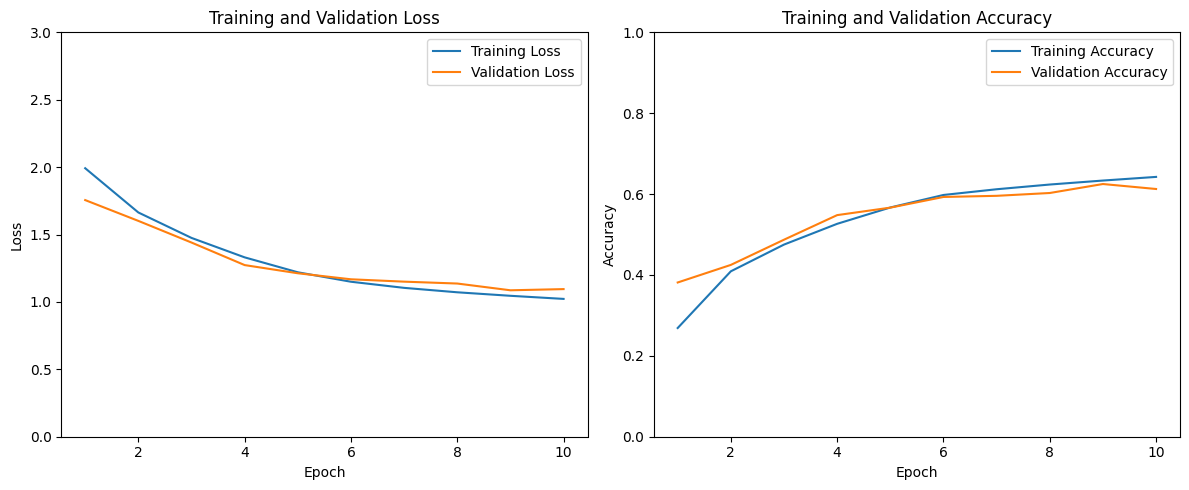

In [ ]:
# Extracting data for plotting
train_losses = history['train_loss']
train_accuracies = history['train_accuracy']
val_losses = history['val_loss']
val_accuracies = history['val_accuracy']
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.3 %
Accuracy for class: car   is 79.1 %
Accuracy for class: bird  is 46.0 %
Accuracy for class: cat   is 28.9 %
Accuracy for class: deer  is 47.7 %
Accuracy for class: dog   is 64.1 %
Accuracy for class: frog  is 77.3 %
Accuracy for class: horse is 64.1 %
Accuracy for class: ship  is 76.5 %
Accuracy for class: truck is 74.6 %


### Confusion Matrix

<Axes: >

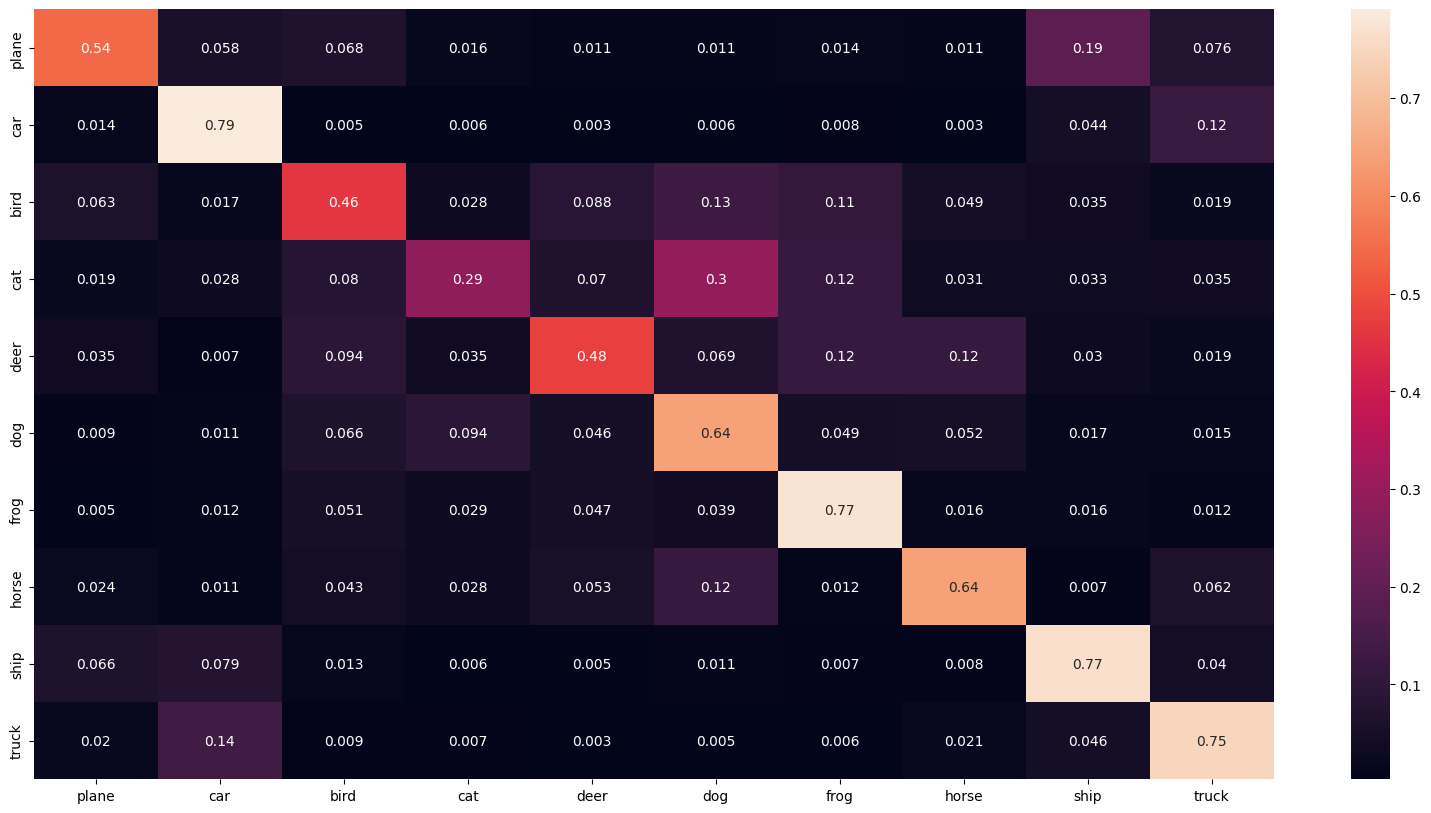

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in test_dataloader:
        #reshape images so they can be fed to a nn.Linear()
        # inputs = inputs.view(inputs.size(0), -1)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')